# Importação de Bibliotecas e Arquivos


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os, cv2
%matplotlib inline

In [2]:
import zipfile
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
arquivo_zip = '/content/drive/MyDrive/Datasets/Mask Detection.zip'
zipf = zipfile.ZipFile(arquivo_zip, 'r')
zipf.extractall('/content/tmp')
zipf.close()

# Carregando Dados

In [4]:
withmask_dir = '/content/tmp/dataset/with_mask'
maskless_dir = '/content/tmp/dataset/without_mask'
withmask = [os.path.join(withmask_dir, x) for x in os.listdir(withmask_dir)]
maskless = [os.path.join(maskless_dir, x) for x in os.listdir(maskless_dir)]

print("With Mask files: ", len(withmask), "\nMaskless files: ", len(maskless))

With Mask files:  220 
Maskless files:  220


In [5]:
all_files = withmask + maskless
images = np.empty(len(all_files), dtype=object)
labels = np.empty(len(all_files), dtype=object)
classes = {0: 'with_mask', 1: 'without_mask'}
for n in range(0, len(all_files)):
  img = cv2.imread(all_files[n])
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img, (256, 256))
  images[n] = img
  labels[n] = 1 if 'without' in all_files[n] else 0

0 1


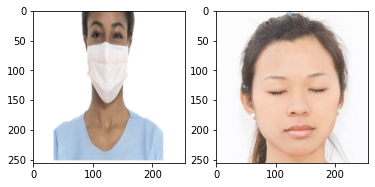

In [6]:
fig, axs = plt.subplots(nrows=1, ncols=2)
axs[0].imshow(images[0])
axs[1].imshow(images[-1])
print(labels[0], labels[-1])

# Divisão dos Dados (sem augmentation)

In [34]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(images.tolist(), labels.tolist(), test_size=0.3, shuffle=True)
X_train = np.asarray(X_train)
X_test = np.asarray(X_test)

print("Formato dos dados de treino -> ", X_train.shape)
print("Formato dos dados de teste  -> ", X_test.shape)

Formato dos dados de treino ->  (308, 256, 256, 3)
Formato dos dados de teste  ->  (132, 256, 256, 3)


In [25]:
y_train_cat = tf.keras.utils.to_categorical(y_train)
y_test_cat = tf.keras.utils.to_categorical(y_test)

In [36]:
print("Formato dos labels de treino -> ", y_train_cat.shape)

Formato dos labels de treino ->  (308, 2)


# Divisão dos Dados (com augmentation)

In [9]:
#@title Funções de Augmentation
import random

def fill(img, h, w):
    img = cv2.resize(img, (256, 256), cv2.INTER_CUBIC)
    return img

def h_shift(img):
  ratio = random.uniform(-0.2, 0.2)
  h,w = img.shape[:2]
  to_shift = w*ratio
  if ratio > 0:
      img = img[:, :int(w-to_shift), :]
  if ratio < 0:
      img = img[:, int(-1*to_shift):, :]
  img = fill(img, h, w)
  return img

def v_shift(img):
  ratio = random.uniform(-0.2, 0.2)
  h, w = img.shape[:2]
  to_shift = h*ratio
  if ratio > 0:
      img = img[:int(h-to_shift), :, :]
  if ratio < 0:
      img = img[int(-1*to_shift):, :, :]
  img = fill(img, h, w)
  return img

def rotation(img):
  angle = int(random.uniform(-30, 30))
  h, w = img.shape[:2]
  M = cv2.getRotationMatrix2D((int(w/2), int(h/2)), angle, 1)
  img = cv2.warpAffine(img, M, (w, h))
  return img

In [10]:
def augment_images(images, labels, array=[], new_labels=[]):

  for n in range(0, len(images)):
    array.append(images[n])
    array.append(rotation(images[n]))
    array.append(h_shift(images[n]))
    array.append(v_shift(images[n]))
    for i in range(0, 4):
      new_labels.append(labels[n])

  return array, new_labels


aug_images, aug_labels = augment_images(images, labels)

0 0 1


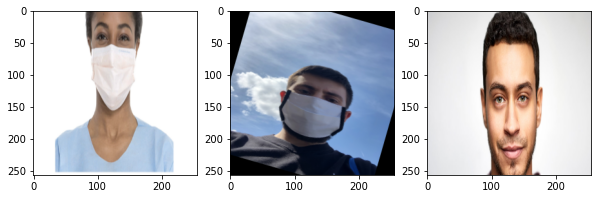

In [11]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10, 8))
axs[0].imshow(aug_images[0])
axs[1].imshow(aug_images[5])
axs[2].imshow(aug_images[-9])
print(labels[0], labels[5], labels[-9])

In [45]:
X_aug_train, X_aug_test, y_aug_train, y_aug_test = train_test_split(aug_images, aug_labels, test_size=0.3, shuffle=True)
X_aug_train = np.array(X_aug_train)
X_aug_test = np.array(X_aug_test)

print("Formato dos dados de treino -> ", X_aug_train.shape)
print("Formato dos dados de teste  -> ", X_aug_test.shape)

Formato dos dados de treino ->  (1232, 256, 256, 3)
Formato dos dados de teste  ->  (528, 256, 256, 3)


In [46]:
y_aug_train_cat = tf.keras.utils.to_categorical(y_aug_train)
y_aug_test_cat = tf.keras.utils.to_categorical(y_aug_test)

# Criação do Modelo

In [40]:
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Dropout
from tensorflow.keras.layers import Normalization, Flatten
from tensorflow.keras.losses import BinaryCrossentropy

modelo = tf.keras.Sequential(
    [
     Normalization(),
     Conv2D(64, kernel_size=(7,7), activation='relu'),
     MaxPool2D(pool_size=(2,2)),
     Conv2D(128, kernel_size=(5,5), activation='relu'),
     MaxPool2D(pool_size=(2,2)),
     Conv2D(256, kernel_size=(3,3), activation='relu'),
     MaxPool2D(pool_size=(2,2)),
     Conv2D(512, kernel_size=(3,3), activation='relu'),
     Conv2D(1024, kernel_size=(3,3), activation='relu'),
     MaxPool2D(pool_size=(2,2)),
     Dense(256, activation='relu'),
     Dense(256, activation='relu'),
     Dropout(.5),
     Flatten(),
     Dense(2, activation='softmax'),
    ]
)

In [41]:
loss_bin = BinaryCrossentropy(from_logits=False)
modelo.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
modelo.fit(x=X_train, y=y_train_cat, batch_size=64, epochs=30, validation_data=(X_test, y_test_cat))

Epoch 1/30
5/5 [==============================] - 70s 5s/step - loss: 40.9301 - accuracy: 0.5065 - val_loss: 0.9407 - val_accuracy: 0.4848
Epoch 2/30
5/5 [==============================] - 5s 934ms/step - loss: 0.8504 - accuracy: 0.4805 - val_loss: 0.6960 - val_accuracy: 0.4394
Epoch 3/30
5/5 [==============================] - 5s 931ms/step - loss: 0.7067 - accuracy: 0.4805 - val_loss: 0.8574 - val_accuracy: 0.5227
Epoch 4/30
5/5 [==============================] - 5s 929ms/step - loss: 0.7370 - accuracy: 0.5032 - val_loss: 0.7045 - val_accuracy: 0.4848
Epoch 5/30
5/5 [==============================] - 5s 926ms/step - loss: 0.6956 - accuracy: 0.5292 - val_loss: 0.6983 - val_accuracy: 0.4848
Epoch 6/30
5/5 [==============================] - 5s 925ms/step - loss: 0.6958 - accuracy: 0.4740 - val_loss: 0.6932 - val_accuracy: 0.5227
Epoch 7/30
5/5 [==============================] - 5s 926ms/step - loss: 0.6939 - accuracy: 0.5065 - val_loss: 0.7018 - val_accuracy: 0.4242
Epoch 8/30
5/5 [=====

In [42]:
y_pred = modelo.predict(X_test)
y_pred[:10]

array([[5.2494305e-01, 4.7505692e-01],
       [1.9687059e-06, 9.9999797e-01],
       [9.9999678e-01, 3.1919699e-06],
       [5.7184809e-01, 4.2815185e-01],
       [5.0814182e-01, 4.9185818e-01],
       [6.0541546e-01, 3.9458454e-01],
       [7.0056891e-01, 2.9943106e-01],
       [5.2963477e-01, 4.7036520e-01],
       [4.5623879e-28, 1.0000000e+00],
       [6.0255616e-07, 9.9999940e-01]], dtype=float32)

In [47]:
loss_bin = BinaryCrossentropy(from_logits=False)
modelo.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
modelo.fit(x=X_aug_train, y=y_aug_train_cat, batch_size=64, epochs=30, validation_data=(X_aug_test, y_aug_test_cat))

Epoch 1/30
20/20 [==============================] - 25s 1s/step - loss: 0.7165 - accuracy: 0.6664 - val_loss: 0.4649 - val_accuracy: 0.7973
Epoch 2/30
20/20 [==============================] - 18s 884ms/step - loss: 0.4311 - accuracy: 0.8182 - val_loss: 0.4697 - val_accuracy: 0.8655
Epoch 3/30
20/20 [==============================] - 18s 887ms/step - loss: 0.3470 - accuracy: 0.8709 - val_loss: 0.3308 - val_accuracy: 0.9091
Epoch 4/30
20/20 [==============================] - 18s 887ms/step - loss: 0.3805 - accuracy: 0.8604 - val_loss: 0.4177 - val_accuracy: 0.8314
Epoch 5/30
20/20 [==============================] - 18s 884ms/step - loss: 0.3337 - accuracy: 0.8620 - val_loss: 0.3684 - val_accuracy: 0.8466
Epoch 6/30
20/20 [==============================] - 18s 885ms/step - loss: 0.2724 - accuracy: 0.8937 - val_loss: 0.5384 - val_accuracy: 0.8845
Epoch 7/30
20/20 [==============================] - 18s 881ms/step - loss: 0.3286 - accuracy: 0.8661 - val_loss: 0.2781 - val_accuracy: 0.9015
Ep